# Multi-Head Example

Up until this example, we have always fed a single logical *data-stream* into the models. Using only one data-stream (head) is very typical in more traditional machine learning.

However, looking closely at the data, we can see that this data-set has fields which we would associate more with the __customer__, like the age and gender. These are fields which will not change from one payment to the next, they are customer properties. And there are fields that will change with every payment, like the amount, merchant and merchant-category, such fields are more associated with the __payment__.

We might for some use-cases want to feed above mentioned field types as separate stream. For a FeedForward this makes less sense, but we'll see examples later were it does. A Neural Net with multiple data streams/inputs is sometimes called a __Multi-Head Neural Net__

*(From a technical perspective the previous examples were already multi-head. The various learning categories were fed to the model each as a data-set. We'll refere to multi-head more from the functional perspective and see them as different __logical__ data-streams)*

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
This `from_csv` method will read the file and return a Pandas DataFrame object. The DataFrame can be used for basic data analysis

In [3]:
# Change this to read from another location
file = '../../../data/bs140513_032310.csv'

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    
df

2021-09-15 15:53:00.897 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:53:00.898 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:53:00.899 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:53:00.899 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../data/bs140513_032310.csv
2021-09-15 15:53:01.075 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-15 15:53:01.075 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-15 15:53:01.077 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 6)
2021-09-15 15:53:01.078 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: base


,age,gender,merchant,category,amount,fraud
0,4,M,M348934600,es_transportation,4.55,0
1,2,M,M348934600,es_transportation,39.68,0
2,4,F,M1823072687,es_transportation,26.89,0
3,3,M,M348934600,es_transportation,17.25,0
4,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...
594638,3,F,M1823072687,es_transportation,20.53,0
594639,4,F,M1823072687,es_transportation,50.73,0
594640,2,F,M349281107,es_fashion,22.44,0
594641,5,M,M1823072687,es_transportation,14.46,0


## Define Derived Features
In order to set-up a multi-head model we define 2 `TensorDefinition` objects, one for each respective head. In this case we  have one for the __Customer__ features and one for the __Transaction__ features. We build each using the `from_df` method from the original *base feature* Pandas DataFrame.

In [6]:
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
age_oh = ft.FeatureOneHot('age_one_hot', ft.FEATURE_TYPE_INT_8, age)
gender_oh = ft.FeatureOneHot('gender_one_hot', ft.FEATURE_TYPE_INT_8, gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', ft.FEATURE_TYPE_INT_8, merchant)
category_oh = ft.FeatureOneHot('category_one_hot', ft.FEATURE_TYPE_INT_8, category)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

cust_learn_features = ft.TensorDefinition(
    'customer-learning', 
    [
        age_oh,
        gender_oh
    ])

trx_learn_features = ft.TensorDefinition(
    'transaction-learning', 
    [
        merchant_oh,
        category_oh,
        amount_scale
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([cust_learn_features, trx_learn_features, label])

with en.EnginePandasNumpy() as e:
    cust_df = e.from_csv(cust_learn_features, file, inference=False)
    trx_df  = e.from_csv(trx_learn_features, file, inference=False)
    lb = e.from_csv(label, file, inference=False)

2021-09-15 15:55:14.881 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:55:14.882 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:55:14.882 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:55:14.882 d373c7.engines.panda_numpy     INFO     Building Panda for : customer-learning from file ../../../data/bs140513_032310.csv
2021-09-15 15:55:15.024 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-15 15:55:15.025 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-15 15:55:15.025 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 2)
2021-09-15 15:55:15.033 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: customer-learning
2021-09-15 15:55:15.035 d373c7.engines.panda_numpy     INFO     Building Panda for : transaction-learning from file ../

In [7]:
# Display Customer feature DataFrame
cust_df

,age__0,age__1,age__2,age__3,age__4,age__5,age__6,age__U,gender__E,gender__F,gender__M,gender__U
0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
594638,0,0,0,1,0,0,0,0,0,1,0,0
594639,0,0,0,0,1,0,0,0,0,1,0,0
594640,0,0,1,0,0,0,0,0,0,1,0,0
594641,0,0,0,0,0,1,0,0,0,0,1,0


In [8]:
# Display Transaction feature DataFrame
trx_df

,merchant__M1053599405,merchant__M117188757,merchant__M1198415165,merchant__M1294758098,merchant__M1313686961,merchant__M1352454843,merchant__M1353266412,merchant__M1400236507,merchant__M1416436880,merchant__M151143676,...,category__es_hotelservices,category__es_hyper,category__es_leisure,category__es_otherservices,category__es_sportsandtoys,category__es_tech,category__es_transportation,category__es_travel,category__es_wellnessandbeauty,amount_scale
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.000546
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.004764
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.003228
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.002071
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.004288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.002465
594639,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.006090
594640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.002694
594641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.001736


In [9]:
# Display the Label feature DataFrame
lb

,fraud_label
0,0
1,0
2,0
3,0
4,0
...,...
594638,0
594639,0
594640,0
594641,0


## Convert to Numpy
Now we convert the panda DataFrame to a list of Numpy arrays (which can be used for training). 

Because we want a multi-head we first set-up a `TensorDefinitionMulti` being a combined definition, including the *Customer* learning features and the *Transactional* learning features. That is what we build the NumpyList object from.

In the ouput we can see that there are 4 Numpy arrays in the NumpyList object. This is one more than in the first example. There is a first list with 12 one-hot features. These are the __Customer Binary__ Learning type features, there is a second list with the 65 __Transaction Binary__ Learning type features, a third list with one __Transaction Continuous__ Learning type features and a fourth list with the __Label__ Learning Type. 

Combined that is still the 78 (-the fraud) features we had in the initial example

In [10]:
with en.EnginePandasNumpy() as e:
    data_list = e.multi_to_numpy_list(model_features, [cust_df, trx_df, lb])
print(data_list.shapes)
print(data_list.dtype_names)

2021-09-15 15:55:53.079 d373c7.engines.common          INFO     Start Engine...
2021-09-15 15:55:53.080 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-15 15:55:53.081 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-15 15:55:53.081 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-15 15:55:53.081 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Binary
2021-09-15 15:55:53.084 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-15 15:55:53.085 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Binary
2021-09-15 15:55:53.099 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: float32
2021-09-15 15:55:53.099 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Continuous
2021-09-15 15:55:53.101 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-15 15:55:53.10

[(594643, 12), (594643, 65), (594643,), (594643,)]
['int8', 'int8', 'float32', 'int8']


## Wrangle the data
Time to split the data. The multihead has no impact on the wrangling. Same as before

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [11]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list, cust_df, trx_df, lb
gc.collect()
print('Done')

Training Data shapes [(464643, 12), (464643, 65), (464643,), (464643,)]
Validation Data shapes [(30000, 12), (30000, 65), (30000,), (30000,)]
Test Data shapes [(100000, 12), (100000, 65), (100000,), (100000,)]
Done


## Set-up Devices 

In [12]:
device, cpu = pt.init_devices()

2021-09-15 15:55:58.652 d373c7.pytorch.common          INFO     Torch Version : 1.9.0+cu111
2021-09-15 15:55:58.701 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-09-15 15:55:58.702 d373c7.pytorch.common          INFO     Cuda Version  : 11.1


# Define Model
The definition of the model is more or less the same as before. Except that we now use the __Multi__ variants of various objects, so we can use the previously definied `TensorDefinitionMulti`.



In [13]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)
train_sampler = pt.ClassSamplerMulti(model_features, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.GeneratedClassifier(model_features, linear_layers=[16])
print(m)

GeneratedClassifier(
  Number of parameters : 1313. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): TensorDefinitionHead(lcs=['Binary'])
    (1): TensorDefinitionHead(lcs=['Binary', 'Continuous'])
  )
  (tail): TailBinary(
    (layers): Sequential(
      (tail_lin_01): Linear(in_features=78, out_features=16, bias=True)
      (tail_act_01): ReLU()
      (tail_dropout_01): Dropout(p=0.1, inplace=False)
      (tail_batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (tail_binary): Linear(in_features=16, out_features=1, bias=True)
      (tail_bin_act): Sigmoid()
    )
  )
)


Graphically the model now looks like below;

Rather than having 1 big *logical* head we have 2. One holds the __Customer__ features the other one the __Transaction__ features. The `TensorHeadModelMulti` concatenates the output of both layers to one layer which has the familiar 78 features. 

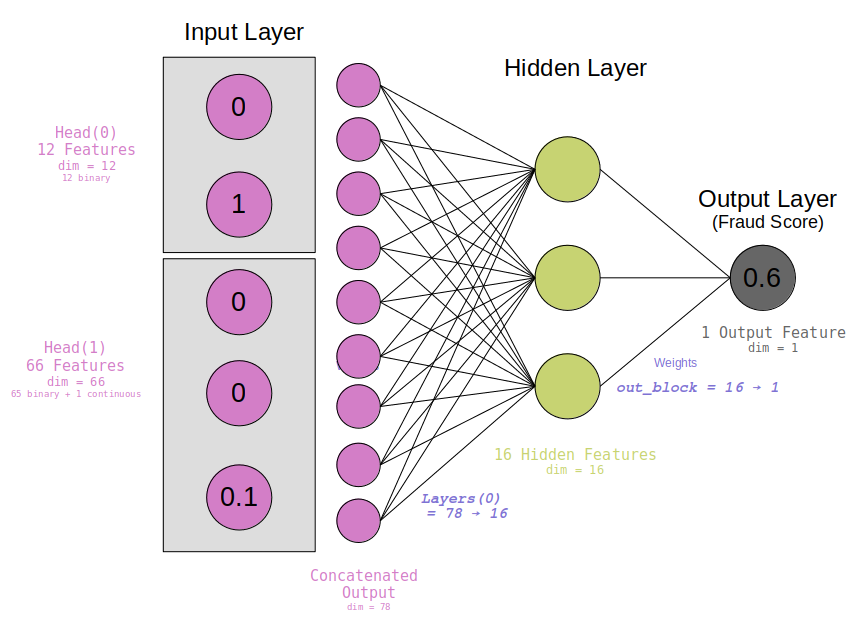

# Start Training

## First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot.

2021-09-15 15:56:03.463 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 441.34it/s]
2021-09-15 15:56:05.504 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


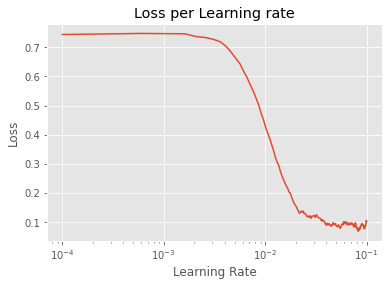

In [14]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 010/010: 100%|██████████| 3866/3866 [00:05<00:00, 680.17it/s, train_loss=0.0553, train_acc=0.978, val_loss=0.0359, val_acc=0.983]


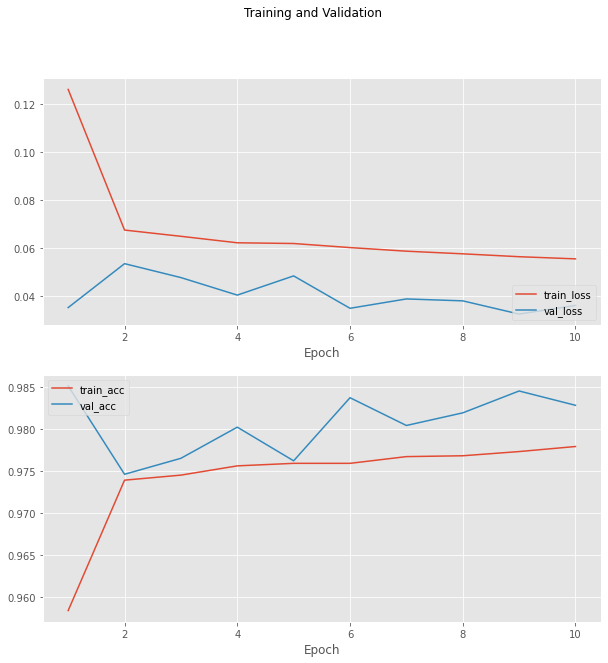

In [15]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. 

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 763.36it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     98926
         1.0       0.42      0.98      0.59      1074

    accuracy                           0.99    100000
   macro avg       0.71      0.98      0.79    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9988
ap score  : 0.9290
-----------------------------------------------------


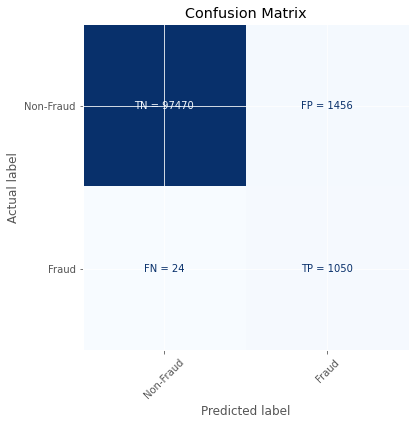

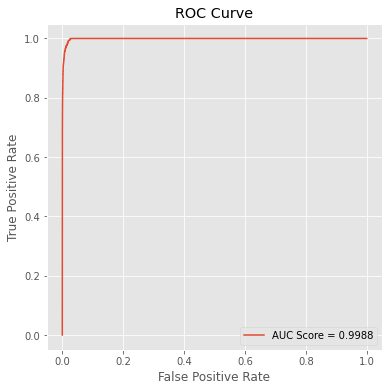

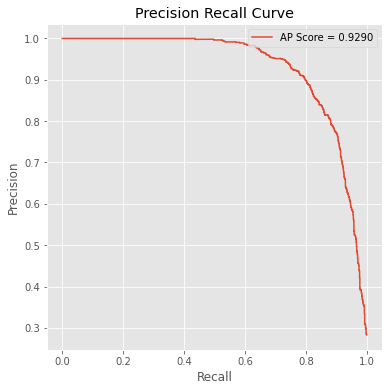

In [16]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

# Conslusion
We showed how to split the input features into various heads. For now this might seem pointless and overly complex. For these examples where all the input/heads are one dimensional, it is indeed overkill. But later we will see examples where this does make sense, where the transaction and customer input will have different dimensions and because of the dimension difference, must be treated differently.